In [1]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import numpy as np
num_classes = 100

In [2]:
# python hw4_bw.py  --resume --epoch 50

# Hyper Parameters
batch_size = 2

# Data Preparation

# note that mean and std is calculated channel-wise
# reference: https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/10
print("Data Preparation...")
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]),
])

train_dataset = torchvision.datasets.CIFAR100(root='../data', train=True, download=True, transform=None)
test_dataset = torchvision.datasets.CIFAR100(root='../data', train=False, download=False, transform=transform_test)

Data Preparation...
Files already downloaded and verified


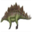

In [15]:
train_dataset[1][0]

In [27]:
a = transforms.RandomCrop(32, padding=1)

In [28]:
b = a(train_dataset[1][0])

In [29]:
b.size

(32, 32)

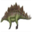

In [30]:
b